In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from IPython.display import display, HTML

In [2]:
# Load Data for Modeling
df = pd.read_csv('../Data/DT.csv')
display(df)
display(HTML("<b>Target Variable:</b> Account"))
display(df['account'].value_counts(normalize=True).to_frame().reset_index(drop=True).style.hide(axis='columns').format('{:.2%}'))

,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,...,agri_sale_3,agri_sale_4,utilities_1,utilities_2,utilities_3,utilities_4,remittances_1,remittances_2,remittances_3,remittances_4
0,0.33,0,18,3,3,1,0,1,0,0,...,False,True,False,True,False,False,False,False,False,True
1,1.33,1,41,1,1,1,1,1,0,0,...,False,True,True,False,False,False,False,False,False,True
2,1.46,1,23,1,2,0,1,1,0,1,...,False,True,False,True,False,False,False,False,False,True
3,0.39,0,17,2,2,1,0,1,0,0,...,False,True,False,False,False,True,False,False,False,True
4,2.42,1,27,1,1,0,1,1,1,0,...,False,True,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,2.11,1,65,1,1,0,1,1,0,1,...,False,True,False,False,False,True,False,False,False,True
2891,0.70,1,32,1,5,0,1,1,0,0,...,False,True,False,True,False,False,True,False,False,False
2892,1.61,1,18,2,2,0,1,0,0,0,...,False,True,False,False,False,True,False,False,False,True
2893,0.84,1,36,2,4,0,1,1,0,1,...,False,True,False,True,False,False,False,False,False,True


0,79.27%
1,20.73%


**Insights:**
1. Unbalanced target variable, stratify and use weights when train-test splits. 

**Notes:**

Split data for training and testing, keeping the same class distribution of target variable. (stratify=y)

In [3]:
# Train Test Split
y = df['account']
X = df.drop(columns=['account','wgt'])
weights = df['wgt']

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
        X, y, weights, test_size=0.25, random_state=24, stratify=y
    )
display(HTML(f"<b>Train size:</b> {X_train.shape} &nbsp;&nbsp; <b>Test size:</b> {X_test.shape}"))

**Insights:**

1. Different Hyperparameters (Tree Depth, Sample size leaf and split criteria) give different testing accuracies.
2. Tune(Select) the Hyperparameters by fitting the trees multiple times for different hyperparameters.
3. Use CrossValidation - Repeatedstratifiedkfold, which is robust for stratified target variable for tuning.
4. Find best Hyperparameters for each scoring criteria.
5. Randomstate-42 for replicability.

**Notes:**

1. CrossValidation: 
    - RepeatedStratifiedkFolds 
    - 5 Folds, Mean of 3 CV Scores
2. HyperParameters for Tuning:  
    - max_depth: [2, 4, 10, 20, None],     
    - min_samples_split: [2, 4, 10, 20, 50],  
    - min_samples_leaf: [2, 4, 10, 20, 50],   
    - criterion: ['gini', 'entropy']
3. Scoring Criteria: 
    - accuracy, f1, roc_auc

In [4]:
# Decision Tree Hyperparameter Tuning with Multiple Scoring Metrics using GridSearchCV
tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [2, 4, 10, 20, None],
    'min_samples_split': [2, 4, 10, 20, 50],
    'min_samples_leaf': [2, 4, 10, 20, 50],
    'criterion': ['gini', 'entropy']
}
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc']

grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring=scoring,
    refit=False,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train, sample_weight=weights_train)

results = pd.DataFrame(grid.cv_results_)
best_params = {}
for metric in scoring:
    best_params[metric] = {
        'params': results.loc[results[f'rank_test_{metric}'].idxmin(), 'params'],
        'cv_score': results.loc[results[f'rank_test_{metric}'].idxmin(), f'mean_test_{metric}']
    }

display(HTML("<b>Best Parameters:</b>"))
for metric, info in best_params.items():
    params = info['params']
    cv_score = info['cv_score']
    display(HTML(f"{metric.upper()}: {params} [CV Score - {cv_score:.4f}]"))

Fitting 15 folds for each of 250 candidates, totalling 3750 fits


**Insights:**

1. max_depth is (4,10) and not 2, 20 or none, this shows 10 is around where the overfitting problem might start.
2. min_samples_leaf is consistently 20, might be because of the small dataset leading to bias with increase in this hyperparameter.
3. min_samples_split is mixed, but we see if depth is more, the overfitting problem is managed by increasing this hyperparameter.
4. To generalise the effect of this hyperparemeters we can visualise this in 3D plot and infer.

**Notes:**

Plot all the model fits in a 3D plot with three hyperparameters for diffirent scoring and split criteria.

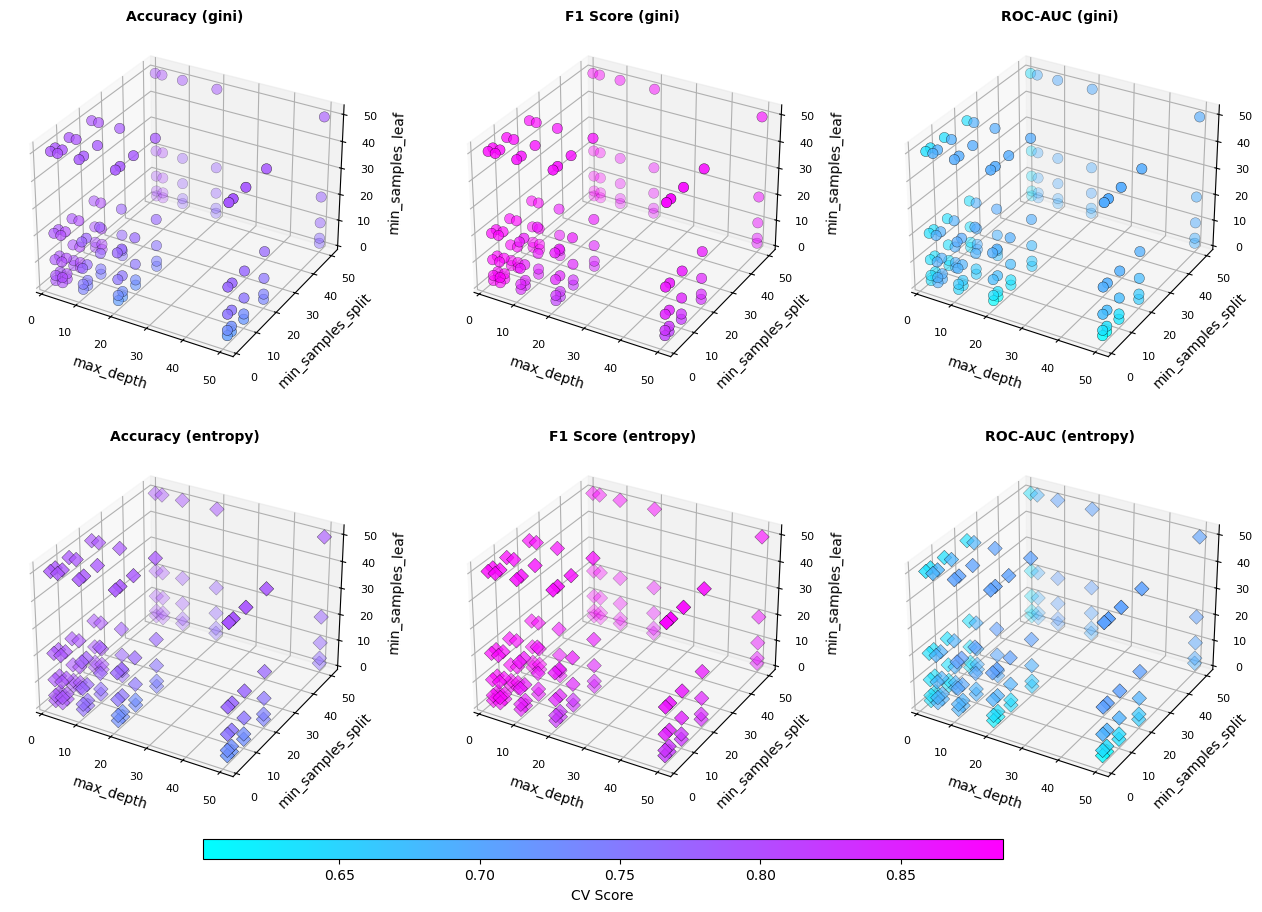

In [5]:
# Visualization: Decision Tree GridSearchCV Results (Gini & Entropy) 
metrics= {
    'Accuracy': 'mean_test_accuracy',
    'F1 Score': 'mean_test_f1',
    'ROC-AUC': 'mean_test_roc_auc'
}
criteria = ['gini', 'entropy']
shapes = {'gini': 'o', 'entropy': 'D'}

cmin = results[['mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']].min().min()
cmax = results[['mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']].max().max()
norm = Normalize(vmin=cmin, vmax=cmax)

fig = plt.figure(figsize=(16, 10))
for i, crit in enumerate(criteria):
    subset = results[results['param_criterion'] == crit]
    x = subset['param_max_depth'].infer_objects(copy=False).fillna(50)
    y = subset['param_min_samples_split']
    z = subset['param_min_samples_leaf']

    for j, (label, metric) in enumerate(metrics.items()):
        ax = fig.add_subplot(2, 3, i*3 + j + 1, projection='3d')
        sc = ax.scatter(x, y, z, c=subset[metric], cmap='cool', norm=norm, s=55, edgecolor='k', linewidth=0.3, marker=shapes[crit]) # type: ignore
        ax.set_title(f"{label} ({crit})", fontsize=10, weight='semibold')
        ax.set_xlabel('max_depth')
        ax.set_ylabel('min_samples_split')
        ax.set_zlabel('min_samples_leaf')  # type: ignore
        ax.tick_params(labelsize=8)

sm = ScalarMappable(norm=norm, cmap='cool')
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02]) # type: ignore
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='CV Score')
plt.show()

In [6]:
# 3D Interactive Plot
fig = go.Figure()
for metric_name, metric_col in metrics.items():
  for crit in criteria:
    subset = results[results['param_criterion'] == crit]
    fig.add_trace(go.Scatter3d(
      x=subset['param_max_depth'].infer_objects(copy=False).fillna(50),
      y=subset['param_min_samples_split'],
      z=subset['param_min_samples_leaf'],
      mode='markers',
      marker=dict(
        size=6, color=subset[metric_col], colorscale='icefire',
        line=dict(width=0.5, color='black'), opacity=0.85,
        colorbar=dict(title="CV Score", thickness=15, len=0.7, x=1.02, y=0.4),
        cmin=cmin, cmax=cmax, symbol = 'circle' if crit == 'gini' else 'diamond'
      ),
      name=f"{metric_name} - {crit.capitalize()}",
      hovertemplate='<b>%{text}</b><extra></extra>',
      text=[f"Depth: {d}<br>Split: {s}<br>Leaf: {l}<br>{metric_name}: {v:.4f}" 
            for d, s, l, v in zip(subset['param_max_depth'], 
                                  subset['param_min_samples_split'],
                                  subset['param_min_samples_leaf'],
                                  subset[metric_col])]
    ))

fig.update_layout(
  template='plotly_white',
  scene=dict(
    xaxis_title='Max Depth', yaxis_title='Min Samples Split', zaxis_title='Min Samples Leaf',
    xaxis=dict(gridcolor='lightgray', showbackground=True),
    yaxis=dict(gridcolor='lightgray', showbackground=True),
    zaxis=dict(gridcolor='lightgray', showbackground=False),
    camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
  ),
  width=800, height=600, margin=dict(l=2, r=0, b=0, t=5),
  showlegend=True,
  legend=dict(
    yanchor="top", y=0.95, xanchor="right", x=1.15,
    bgcolor="rgba(255,255,255,0.8)", bordercolor="gray", borderwidth=1
  )
)
fig.show()

**Insights:**

1. min_sample_split, there is a clear relation -> Scoring is decreased with increase in min_samples_split.
2. There is clear substitution effect between max_depth and min_sample_leaf. max_depth can be increased with increase in min_sampe_leaf maintaining the score.
3. There is no significant difference in scores between gini and entropy criteria for all the scoring criteria results.
4. From visualisation insights above, we select f1 best hyperparameters and gini as criteria. Less depth also gives explainability.
5. min_impurity_decrease hyperparameter is added to avoid high overfitting, unnecessary splits and maintain simple, generalised model. (very small value)

**Notes:**

Use the following hyperparameters based on tuning and other insights above for modelling the decision tree.
- Criterion: gini
- Max Depth: 10
- Min Sample in Leaf: 50
- Min Sampls for Split: 2
- Min Impurity Decrease needed for Split: 0.001

Random State for Replicability: 42

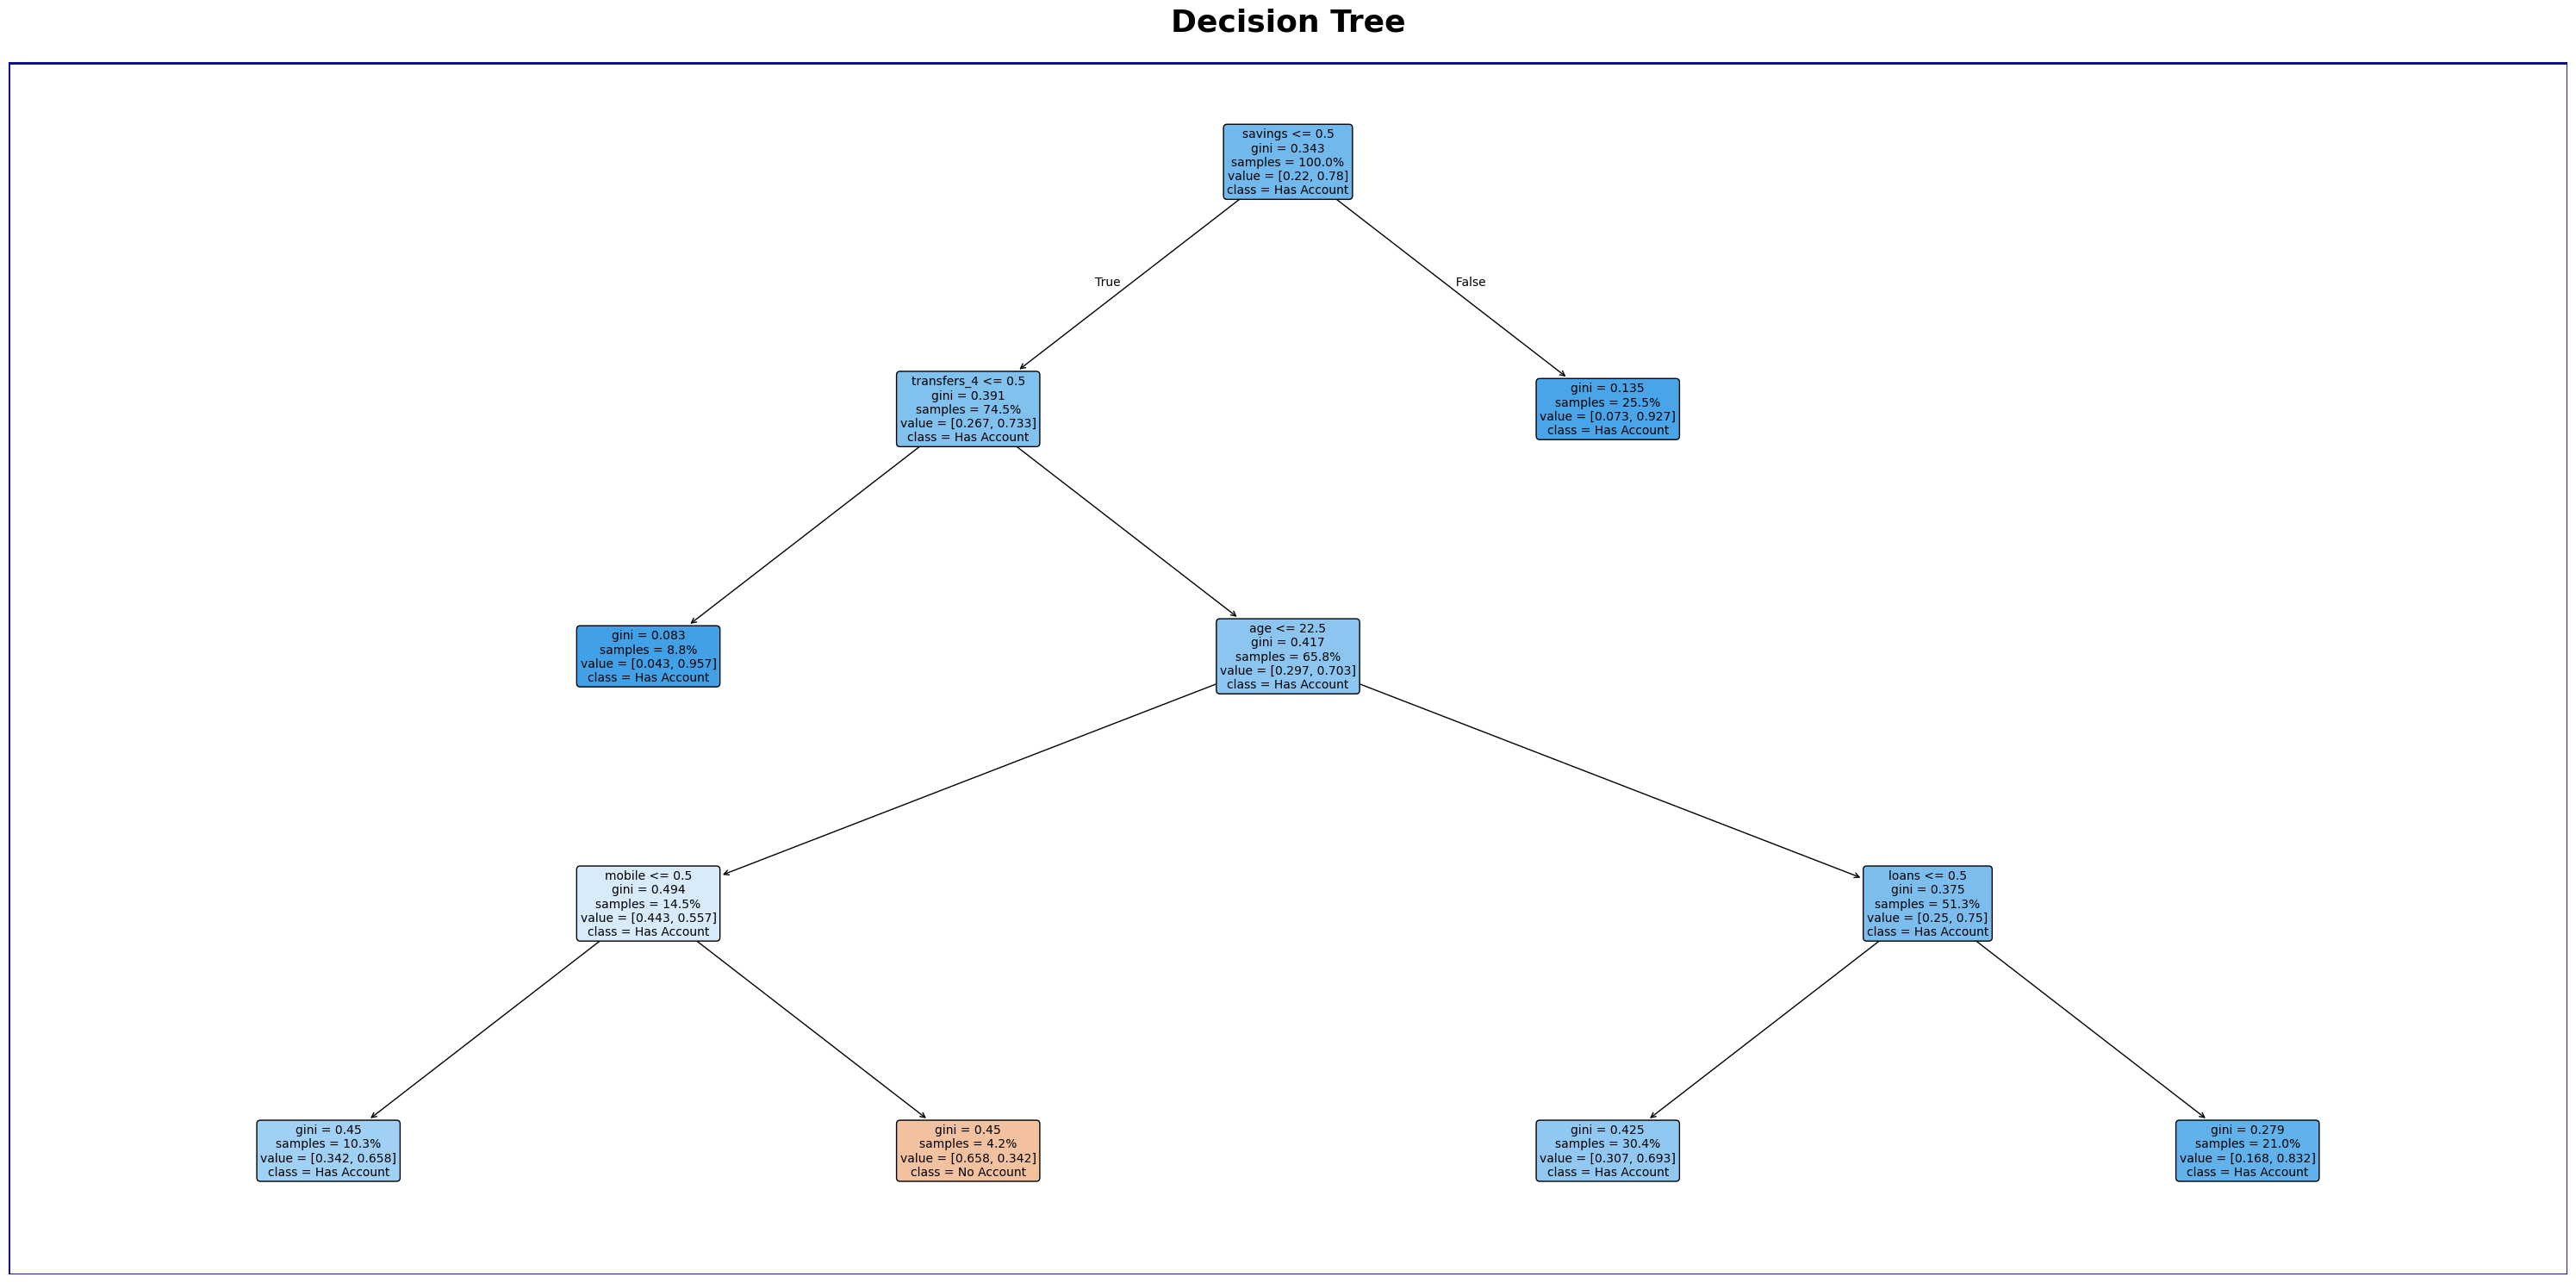

In [7]:
# Visualizing the Decision Tree
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=20, min_impurity_decrease=0.001, min_samples_split=2, random_state=42)
tree.fit(X_train, y_train, sample_weight=weights_train)

fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(
    tree,
    feature_names=list(X.columns),
    class_names=['No Account', 'Has Account'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    ax=ax
)
plt.title("Decision Tree", fontsize=26, weight='bold')
rect = mpatches.Rectangle((0, 0), 1, 0.98, transform=ax.transAxes, fill=False, edgecolor='darkblue', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

display(HTML(
    f"""<center>
        <b>Tree depth:</b> {tree.get_depth()} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Train Score:</b> {tree.score(X_train, y_train):.4f} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Test Score:</b> {tree.score(X_test, y_test):.4f}
        </center>
    """
))

**Insights:**
1. Test and Train Score slightly improved from min_impurity_decrease.
2. Check for FP and FN to train the model according to policy implications(costs).

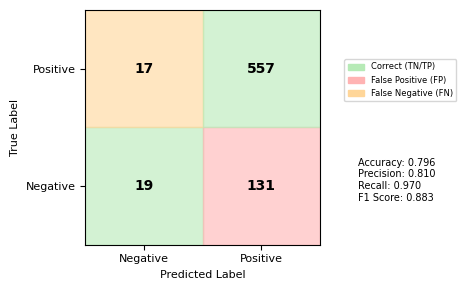

Model              TN     FP     FN     TP     Type I   Type II 
-----------------------------------------------------------------
Decision Tree      19     131    17     557    0.873    0.030   


In [8]:
# Confusion Matrix
y_pred = tree.predict(X_test)
metrics = (
    f'Accuracy: {accuracy_score(y_test, y_pred):.3f}\n'
    f'Precision: {precision_score(y_test, y_pred):.3f}\n'
    f'Recall: {recall_score(y_test, y_pred):.3f}\n'
    f'F1 Score: {f1_score(y_test, y_pred):.3f}\n'
)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
type_i_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
type_ii_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

cell_colors = np.array([
    ['#b6eab6', '#ffb3b3'],  # TN, FP
    ['#ffd699', '#b6eab6']   # FN, TP
])

fig, ax = plt.subplots(figsize=(6, 3))
for (row, col), val in np.ndenumerate(cm):
    ax.add_patch(mpatches.Rectangle((col, row), 1, 1, color=cell_colors[row, col], alpha=0.6))
    ax.text(col + 0.5, row + 0.5, str(val), va='center', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(['Negative', 'Positive'], fontsize=8)
ax.set_yticklabels(['Negative', 'Positive'], fontsize=8)
ax.set_xlabel('Predicted Label', fontsize=8)
ax.set_ylabel('True Label', fontsize=8)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.grid(False)
ax.set_aspect('equal')

ax.text(2.32, 0.5, metrics, fontsize=7, va='center', ha='left')

legend_patches = [
    mpatches.Patch(color='#b6eab6', label='Correct (TN/TP)'),
    mpatches.Patch(color='#ffb3b3', label='False Positive (FP)'),
    mpatches.Patch(color='#ffd699', label='False Negative (FN)')
]
fig.legend(handles=legend_patches, bbox_to_anchor=(0.93, 0.8), ncol=1, fontsize=6, frameon=True)

plt.tight_layout()
plt.show()

print(f"{'Model':<18} {'TN':<6} {'FP':<6} {'FN':<6} {'TP':<6} {'Type I':<8} {'Type II':<8}")
print("-" * 65)
print(f"{'Decision Tree':<18} {tn:<6} {fp:<6} {fn:<6} {tp:<6} {type_i_rate:<8.3f} {type_ii_rate:<8.3f}")


**Insights:**

1. Type I Error (FP) is high.
2. Check if ROC curves are robust for threshold optimisation.

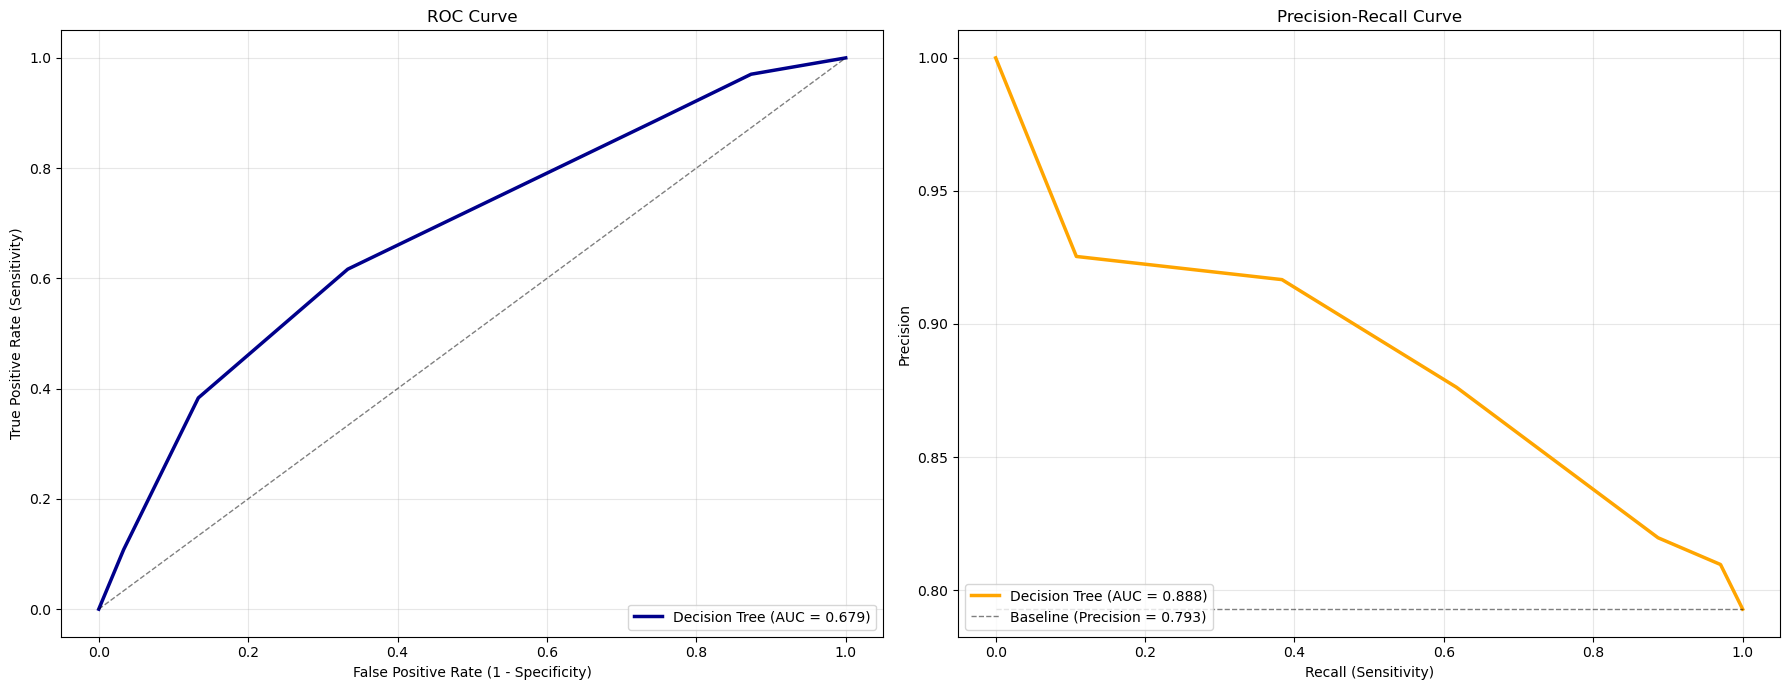

In [9]:
# ROC and Precision-Recall Curves
y_prob = tree.predict_proba(X_test)[:, 1] # type: ignore

plt.figure(figsize=(18, 7))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkblue', lw=2.5,
         label=f'Decision Tree (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
baseline = y_test.mean()

plt.plot(recall, precision, color='orange', lw=2.5,
         label=f'Decision Tree (AUC = {pr_auc:.3f})')
plt.plot([0, 1], [baseline, baseline], 'k--', lw=1, alpha=0.5,
         label=f'Baseline (Precision = {baseline:.3f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Insights:**

1. ROC Score is not too high and the curve comprimises true positive rate much on decreasing false positive rate.
2. Set Cost Scenerios to minimize FP and FN.


Cost Scenarios:
- Balanced Costs: Type I Cost = 1, Type II Cost = 1
- High FN Cost: Type I Cost = 1, Type II Cost = 2.5
- High FP Cost: Type I Cost = 2.5, Type II Cost = 1


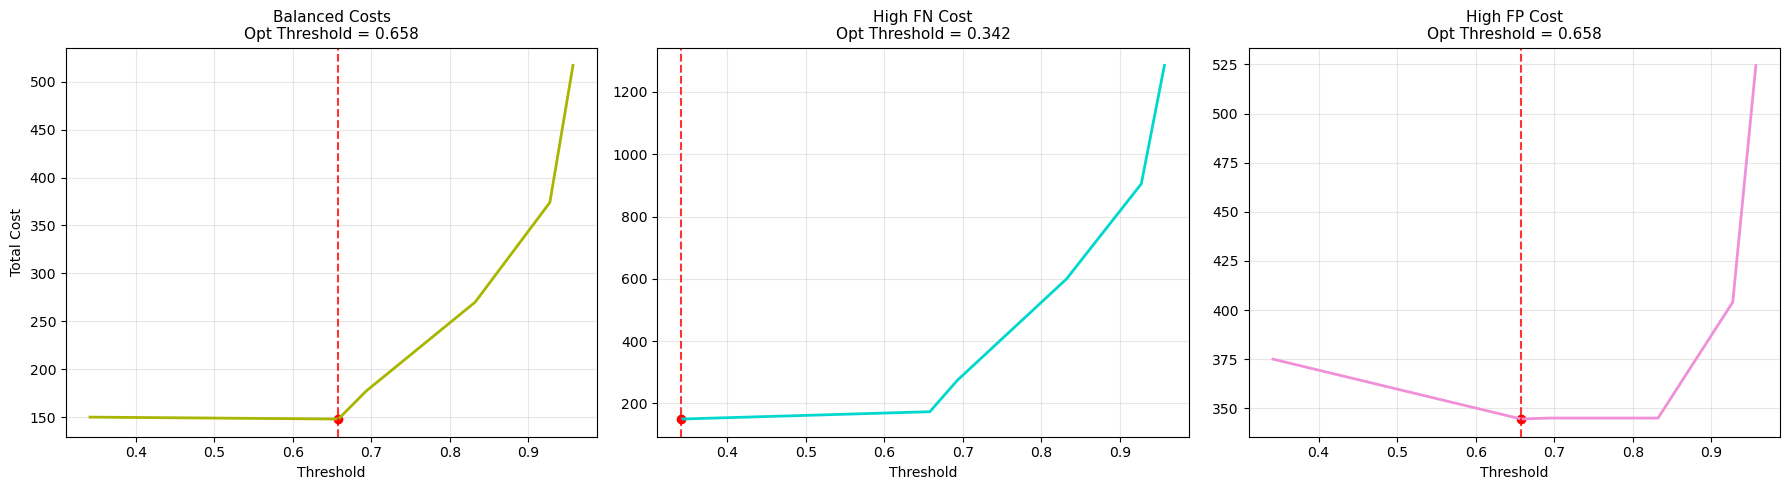


Threshold Optimization Summary:
Scenario                            │ Opt_Thr  │ Total_Cost │ Acc     │ Prec     │ Rec     │ F1      │ FP  │ FN 
Balanced Costs                      │ 0.658    │ 148.0      │ 0.796   │ 0.81     │ 0.97    │ 0.883   │ 131 │ 17 
High FN Cost                        │ 0.342    │ 150.0      │ 0.793   │ 0.793    │ 1.0     │ 0.884   │ 150 │ 0  
High FP Cost                        │ 0.658    │ 344.5      │ 0.796   │ 0.81     │ 0.97    │ 0.883   │ 131 │ 17 


In [10]:
# Threshold Optimization for Decision Tree (ROC-PR AUC) with Cost Scenarios
cost_scenarios = {
    'Balanced Costs': {'cost_fp': 1, 'cost_fn': 1},
    'High FN Cost':   {'cost_fp': 1, 'cost_fn': 2.5},
    'High FP Cost':   {'cost_fp': 2.5, 'cost_fn': 1}
}
print("\nCost Scenarios:")
for scenario, costs in cost_scenarios.items():
    print(f"- {scenario}: Type I Cost = {costs['cost_fp']}, Type II Cost = {costs['cost_fn']}")

colors = ["#a7b600", "#00d8cd", "#ef90d9"]
results = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (scenario, costs) in enumerate(cost_scenarios.items()):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    total_costs = []

    for thr in thresholds:
        preds = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        total_costs.append(fp * costs['cost_fp'] + fn * costs['cost_fn'])
    total_costs = np.array(total_costs)
    opt_idx = np.argmin(total_costs)
    opt_thr, opt_cost = thresholds[opt_idx], total_costs[opt_idx]

    preds_opt = (y_prob >= opt_thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_opt).ravel()
    acc = accuracy_score(y_test, preds_opt)
    prec = precision_score(y_test, preds_opt)
    rec = recall_score(y_test, preds_opt)
    f1 = f1_score(y_test, preds_opt)

    ax = axes[i]
    ax.plot(thresholds, total_costs, color=colors[i], lw=2)
    ax.axvline(opt_thr, color='red', ls='--', alpha=0.8)
    ax.scatter(opt_thr, opt_cost, color='red')
    ax.set_title(f"{scenario}\nOpt Threshold = {opt_thr:.3f}", fontsize=11)
    ax.set_xlabel('Threshold')
    if i == 0: ax.set_ylabel('Total Cost')
    ax.grid(alpha=0.3)

    results.append({
        'Scenario': scenario, 'Opt_Threshold': round(opt_thr, 3), 'Total_Cost': round(opt_cost, 2),
        'Accuracy': round(acc, 3), 'Precision': round(prec, 3),  # type: ignore
        'Recall': round(rec, 3), 'F1_Score': round(f1, 3), # type: ignore
        'FP': fp, 'FN': fn
    })
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nThreshold Optimization Summary:")
print("=" * 125)
print(f"{'Scenario':<35} │ {'Opt_Thr':<8} │ {'Total_Cost':<10} │ {'Acc':<7} │ {'Prec':<8} │ {'Rec':<7} │ {'F1':<7} │ {'FP':<3} │ {'FN':<3}")
print("=" * 125)
for _, r in results_df.iterrows():
    print(f"{r['Scenario']:<35} │ {r['Opt_Threshold']:<8} │ {r['Total_Cost']:<10} │ "
          f"{r['Accuracy']:<7} │ {r['Precision']:<8} │ {r['Recall']:<7} │ {r['F1_Score']:<7} │ "
          f"{r['FP']:<3} │ {r['FN']:<3}")
print("=" * 125)

**Insights:**

1. High FP and Balnced costs have same threshold - 0.658
2. FP doesnt change inspite high costs, hence the model cannot reduce false positives without damaging accuracy.
3. FN Costs, Reduces FN to 0, and also total cost remains the same, but it increase F1 even further keeping accuracy constant.

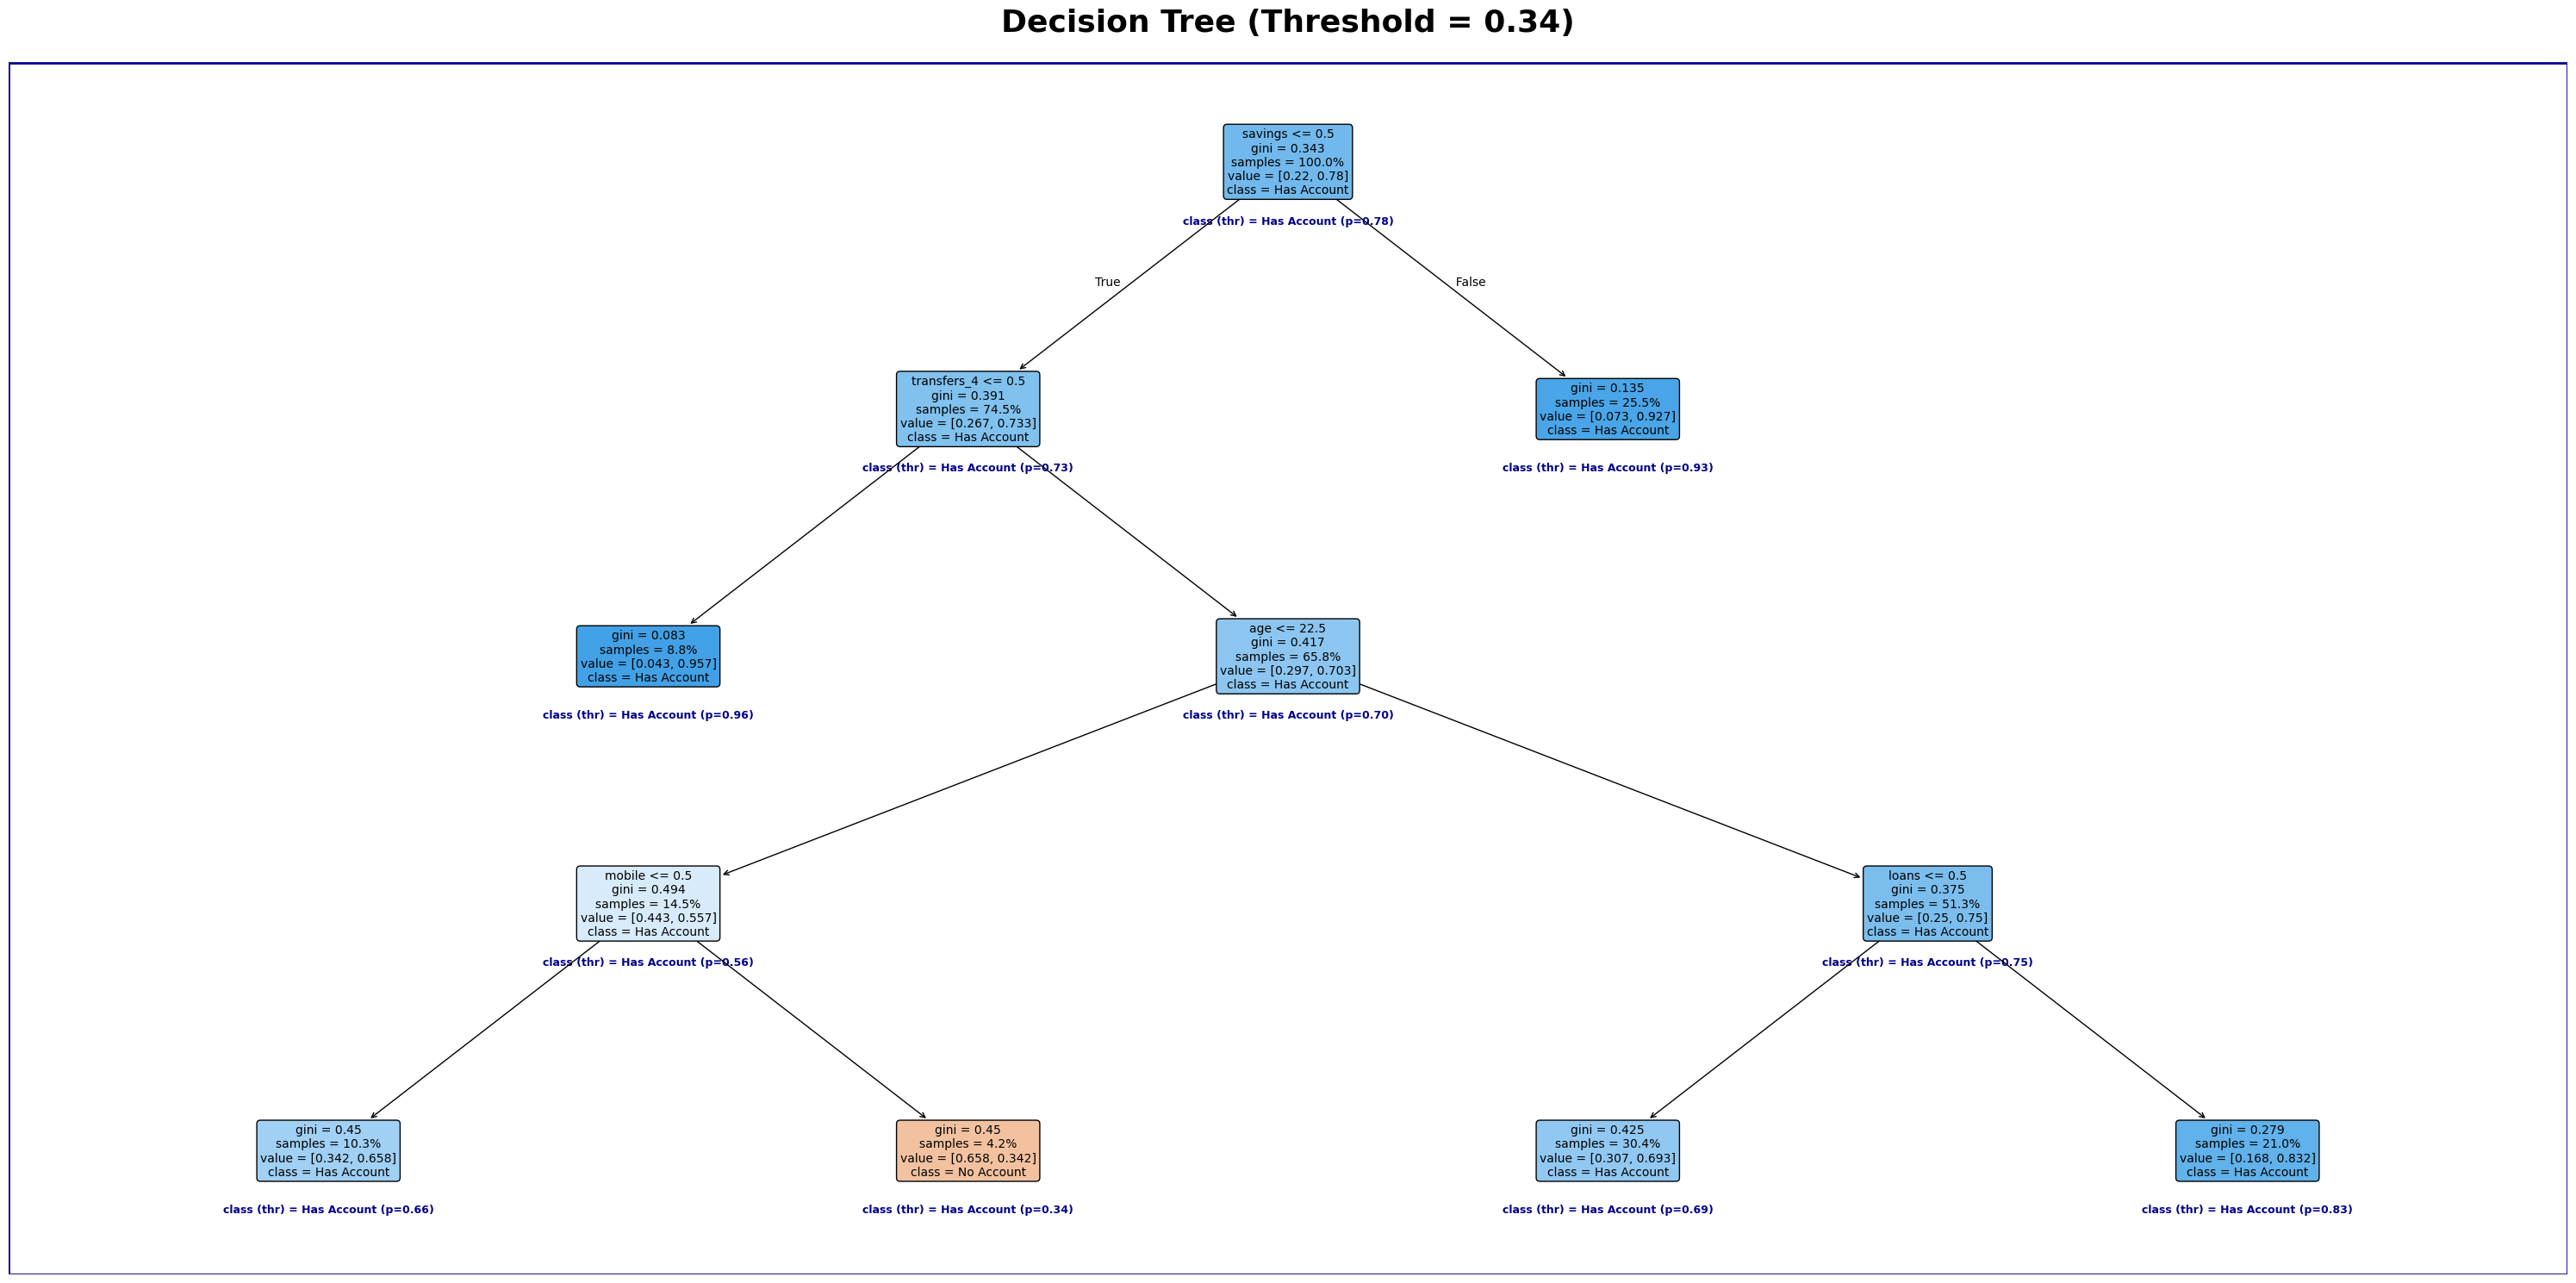

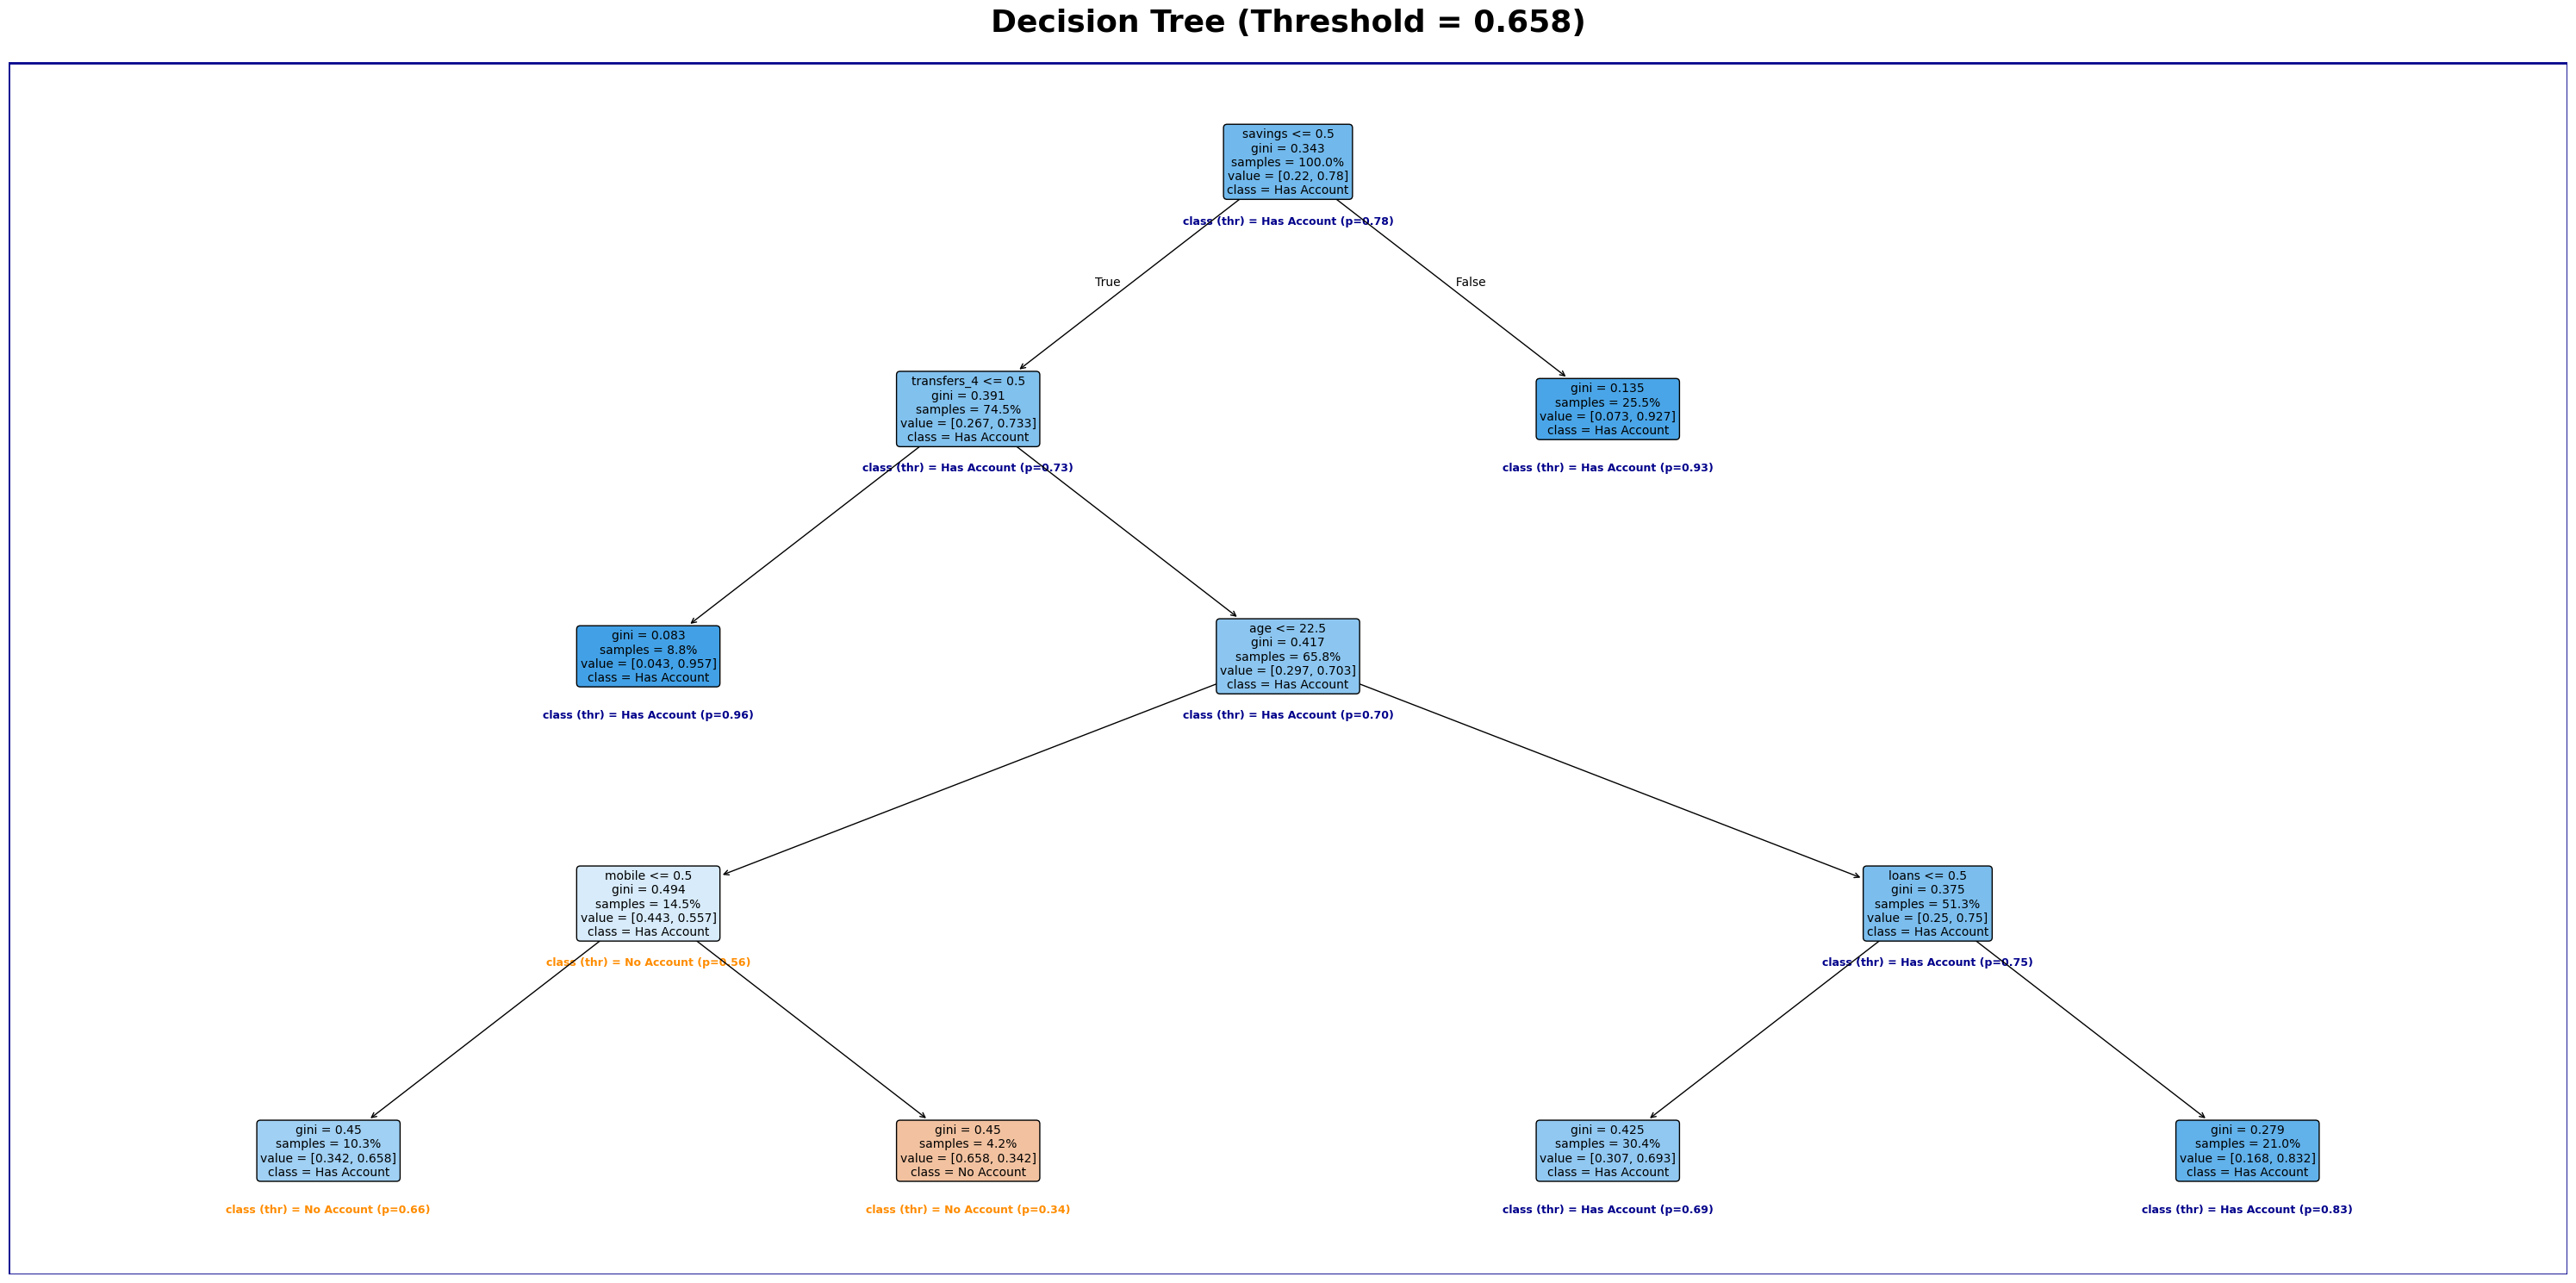

In [11]:
# Visualising the Decision Tree with Cost Adjusted Threshold
threshold = 0.34

y_train_prob = tree.predict_proba(X_train)[:, 1] # type: ignore
y_test_prob = tree.predict_proba(X_test)[:, 1] # type: ignore
y_train_pred = (y_train_prob >= threshold).astype(int)
y_test_pred = (y_test_prob >= threshold).astype(int)
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

values = tree.tree_.value.squeeze()
if values.ndim == 1:
    values = values.reshape(-1, 2)
node_probs = values[:, 1] / values.sum(axis=1)

fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(
    tree,
    feature_names=list(X.columns),
    class_names=['No Account', 'Has Account'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    ax=ax
)
plt.title(f"Decision Tree (Threshold = {threshold})", fontsize=26, weight='bold')
rect = mpatches.Rectangle((0, 0), 1, 0.98, transform=ax.transAxes, fill=False, edgecolor='darkblue', linewidth=2)
ax.add_patch(rect)

value_texts = [t for t in ax.texts if 'value' in t.get_text()]
for i, txt in enumerate(value_texts):
    if i >= len(node_probs):
        break
    prob = node_probs[i]
    cls = 'Has Account' if prob >= threshold else 'No Account'
    color = 'darkblue' if cls == 'Has Account' else 'darkorange'
    x, y = txt.get_position()
    ax.text(
        x, y - 0.05,
        f'class (thr) = {cls} (p={prob:.2f})',
        ha='center',
        fontsize=9,
        color=color,
        weight='semibold'
    )
plt.tight_layout()
plt.show()

display(HTML(
    f"""<center>
        <b>Tree depth:</b> {tree.get_depth()} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Train Score:</b> {train_score:.4f} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Test Score:</b> {test_score:.4f}
        </center>
    """
))

threshold = 0.658

y_train_prob = tree.predict_proba(X_train)[:, 1] # type: ignore
y_test_prob = tree.predict_proba(X_test)[:, 1] # type: ignore
y_train_pred = (y_train_prob >= threshold).astype(int)
y_test_pred = (y_test_prob >= threshold).astype(int)
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

values = tree.tree_.value.squeeze()
if values.ndim == 1:
    values = values.reshape(-1, 2)
node_probs = values[:, 1] / values.sum(axis=1)

fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(
    tree,
    feature_names=list(X.columns),
    class_names=['No Account', 'Has Account'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    ax=ax
)
plt.title(f"Decision Tree (Threshold = {threshold})", fontsize=26, weight='bold')
rect = mpatches.Rectangle((0, 0), 1, 0.98, transform=ax.transAxes, fill=False, edgecolor='darkblue', linewidth=2)
ax.add_patch(rect)

value_texts = [t for t in ax.texts if 'value' in t.get_text()]
for i, txt in enumerate(value_texts):
    if i >= len(node_probs):
        break
    prob = node_probs[i]
    cls = 'Has Account' if prob >= threshold else 'No Account'
    color = 'darkblue' if cls == 'Has Account' else 'darkorange'
    x, y = txt.get_position()
    ax.text(
        x, y - 0.05,
        f'class (thr) = {cls} (p={prob:.2f})',
        ha='center',
        fontsize=9,
        color=color,
        weight='semibold'
    )
plt.tight_layout()
plt.show()

display(HTML(
    f"""<center>
        <b>Tree depth:</b> {tree.get_depth()} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Train Score:</b> {train_score:.4f} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Test Score:</b> {test_score:.4f}
        </center>
    """
))

**Insights:**

1. Tree remains the same, prediction of class differ due to threshold.
2. At threshold for higher FN costs, it predicts positive for everyting.
3. Balanced cost threshold is 0.658, so in the range of threshold(0.342-0658), there are same predictions.
3. Compare higher FP cost model performance with initial balancd model to check if it is as desired.

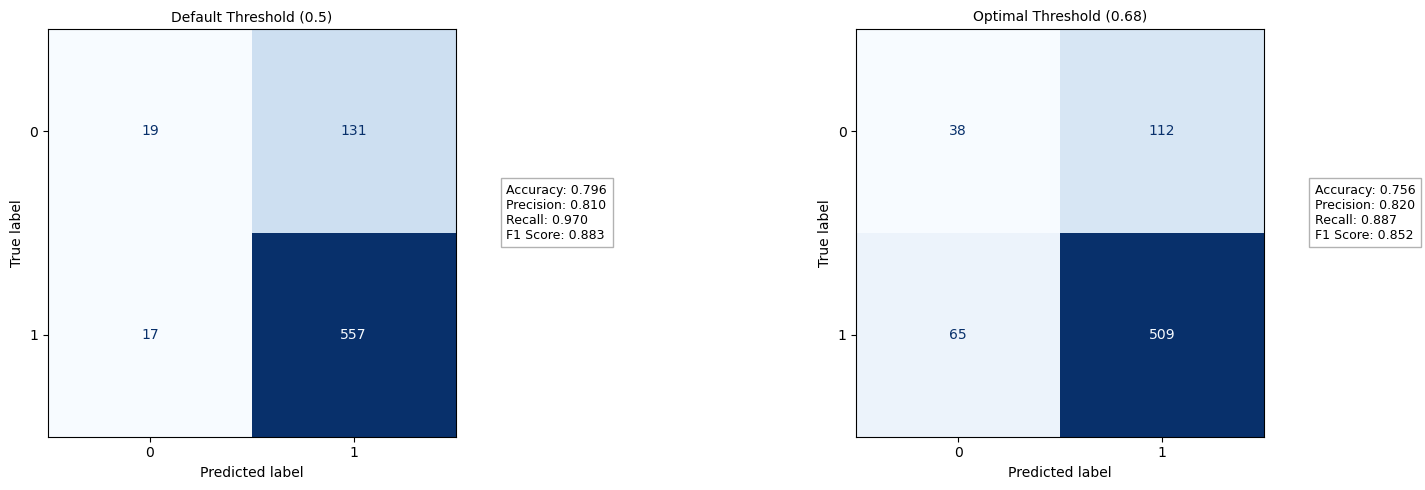

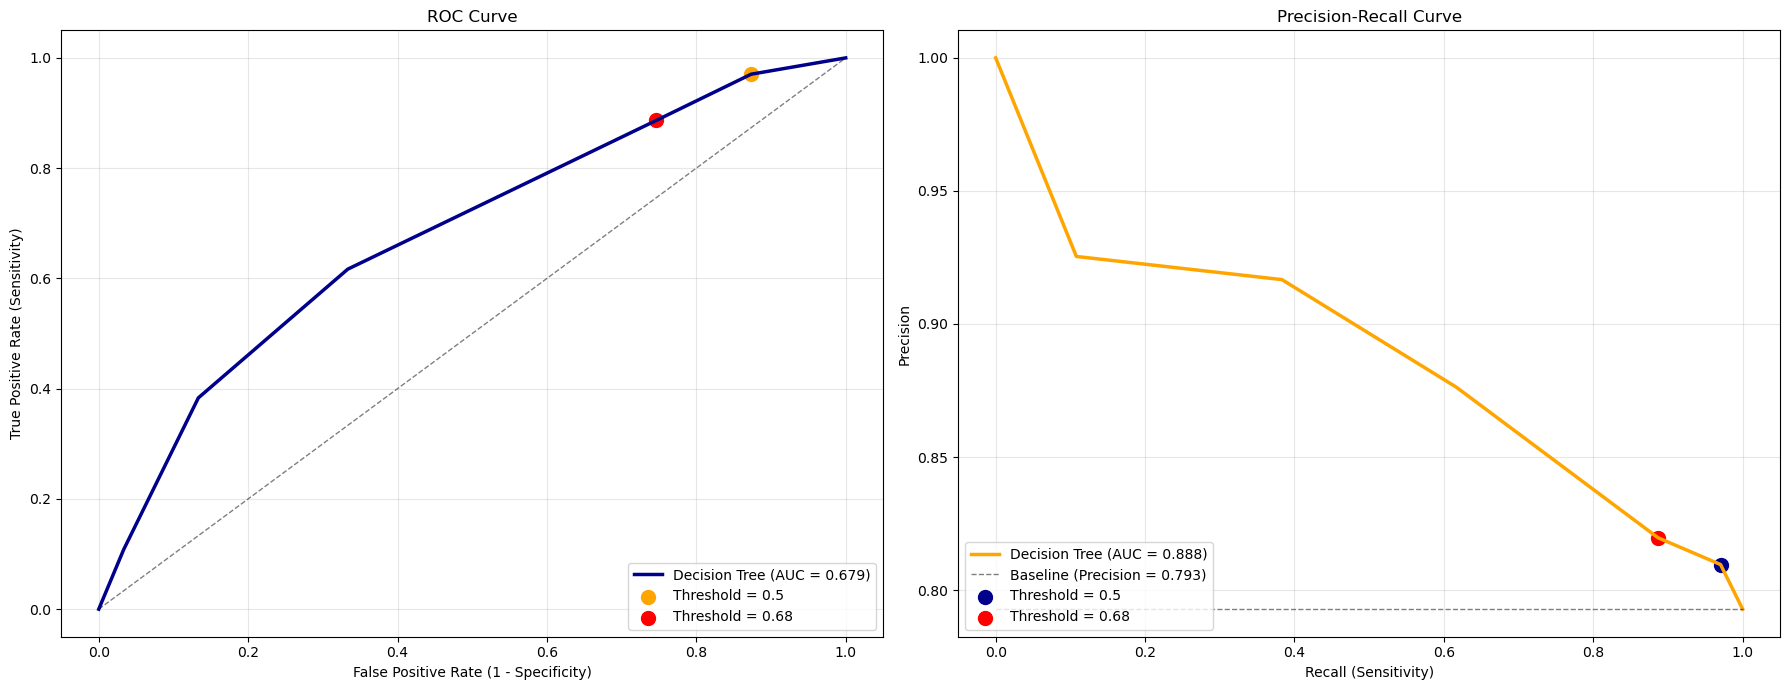

In [12]:
# Model Performance at Adjusted Threshold
threshold = 0.68
y_prob = tree.predict_proba(X_test)[:, 1] # type: ignore

y_pred_default = (y_prob >= 0.5).astype(int)
y_pred_opt = (y_prob >= threshold).astype(int)
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
titles = ['Default Threshold (0.5)', f'Optimal Threshold ({threshold})']
for ax, preds, title in zip(axes, [y_pred_default, y_pred_opt], titles):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    metrics = (
    f'Accuracy: {accuracy_score(y_test, preds):.3f}\n'
    f'Precision: {precision_score(y_test, preds):.3f}\n'
    f'Recall: {recall_score(y_test, preds):.3f}\n'
    f'F1 Score: {f1_score(y_test, preds):.3f}'
    )
    ax.text(1.75, 0.4, metrics, fontsize=9, va='center', ha='left', bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
    ax.set_title(title, fontsize=10, weight='normal')   
plt.tight_layout()
plt.show()

fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
baseline = y_test.mean()

def find_nearest_idx(array, value):
    return np.argmin(np.abs(array - value))
roc_idx_default = find_nearest_idx(roc_thresholds, 0.5)
roc_idx_opt = find_nearest_idx(roc_thresholds, threshold)
pr_idx_default = find_nearest_idx(pr_thresholds, 0.5)
pr_idx_opt = find_nearest_idx(pr_thresholds, threshold)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkblue', lw=2.5,
         label=f'Decision Tree (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
plt.scatter(fpr[roc_idx_default], tpr[roc_idx_default],
            color='orange', s=100, label='Threshold = 0.5')
plt.scatter(fpr[roc_idx_opt], tpr[roc_idx_opt],
            color='red', s=100, label=f'Threshold = {threshold}')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='orange', lw=2.5,
         label=f'Decision Tree (AUC = {pr_auc:.3f})')
plt.plot([0, 1], [baseline, baseline], 'k--', lw=1, alpha=0.5,
         label=f'Baseline (Precision = {baseline:.3f})')
plt.scatter(recall[pr_idx_default], precision[pr_idx_default],
            color='darkblue', s=100, label='Threshold = 0.5')
plt.scatter(recall[pr_idx_opt], precision[pr_idx_opt],
            color='red', s=100, label=f'Threshold = {threshold}')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Insights:**

1. This threshold comprimises accuracy and recall for slight precision, scores are relatively the same.
2. Beyond the threshold(0.5) marker as seen in the curve, the slope increases, causing equal fall in precison and recall.

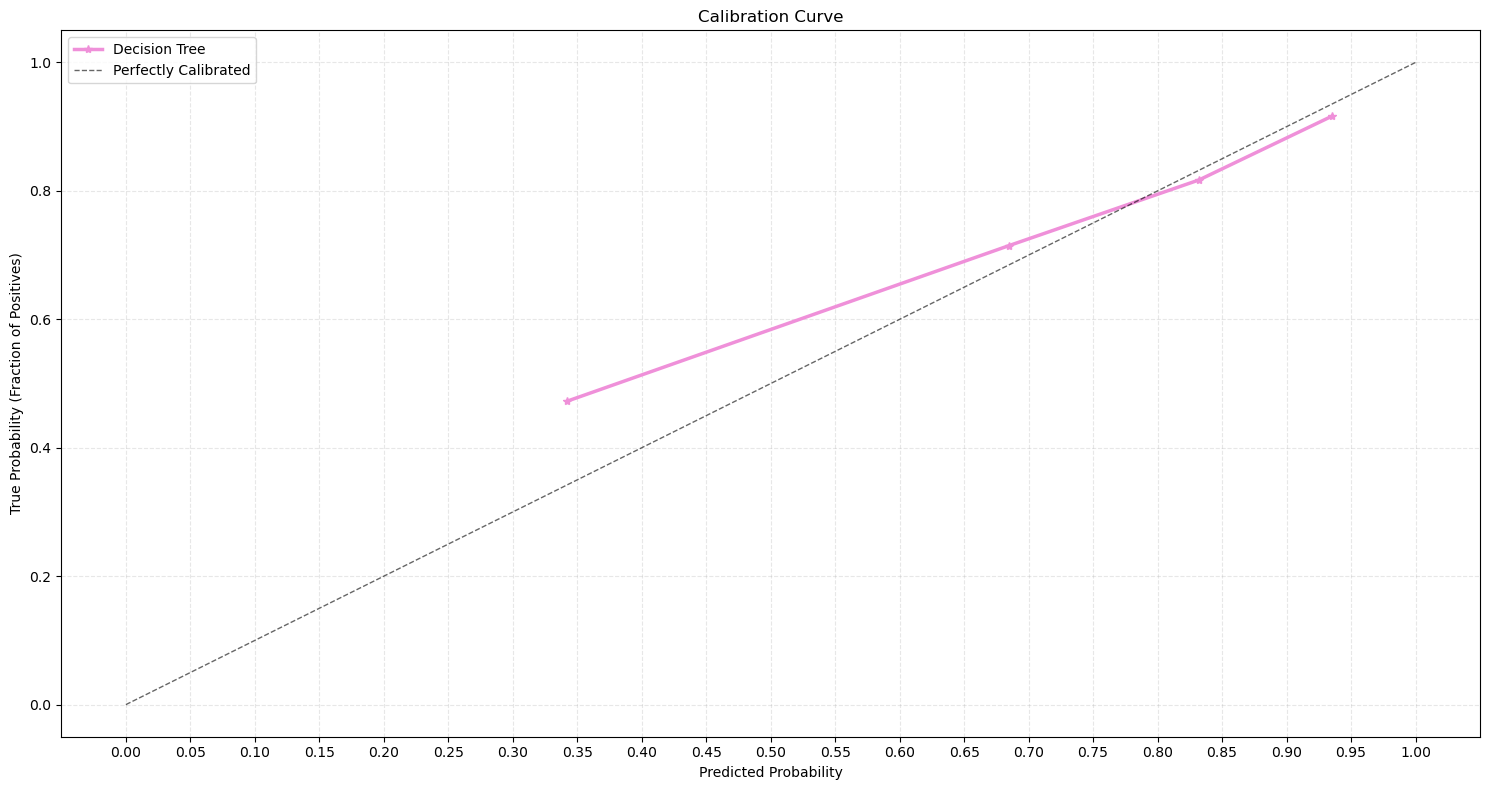

In [13]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

# Plot Calibration Curve
plt.figure(figsize=(15, 8))
plt.plot(prob_pred, prob_true, marker='*', color='#ef90d9', lw=2.5, label='Decision Tree')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.6, label='Perfectly Calibrated')

plt.xticks(np.arange(0.0, 1.05, 0.05))
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability (Fraction of Positives)')
plt.title('Calibration Curve')
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Insights:**

1. Decision Tree is well calibrated at low probabilities.
2. It overestimates at higher predicted probabilities.
3. In general the model is cautious.

**Decision Tree:**

---
Balanced:

1. Only one leaf has the class no account, shows the high financial inclusion in the data and prediction as well.
2. No account node stems from mobile phone users who are of age less than 22.5, did not perform any payment transfers and do not have loans or savings.
3. Rest nodes predict having an account. Only youngsters who do not use financial services do not have a account.
4. This shows high financial inclusion in India. 

When Tree Depth is not adjusted, and tried with max depth 10 and increasing min leaf condition to 50, we saw that no account node stemed from mobile phone users who are of age less than 21, did not perform any payment transfers and do not have loans or savings.

This is also very intutive.

---
Threshold Adjusted - FP Cost(2.5):

For depth 4, we saw all the nodes less than age 22.5 to not have any account.
This is because of the FP costs. Model predicts all under age 22.5 to have no account because few FP lie in this mobile splits, which it avoids due, as costs make it more cautious.

For depth 10, following were noticed
1. Many nodes have the class no account, shows influence of these features in predicting financial inclusion.
2. Major no account predicting nodes stem from the node which takes no loans. (loans<0.5)
3. Only case where it predicts no account is where there is no internet access and lie in low income quartile, inspite having loans.
3. Other nodes such as transfers, age, mobile access and utilities explain financial inclusion.
4. This shows how certain features have impact on financial inclusion and can help select the target groups.